# OneVis


In [3]:
import os
import numpy as np
import pandas as pd
import altair as alt

# Demographic Data

In [4]:
#Demographics
stdempath = os.path.join(os.getcwd(),'data','US_Demographic_Presidential_Results_04-16.csv')
#Note, many of these values are from here, just the uncorrected ones:
#http://www.electproject.org/home/voter-turnout/demographics
#https://docs.google.com/spreadsheets/d/1l5fpK7ysQhQbZPv9hnZ_-PO1J1zBVPXSSQjNejTXecY/edit#gid=0
stdem_df = pd.read_csv(stdempath)
stdem_df.rename(columns={'demographic':'category'}, inplace=True)
stdem_df['num'] = stdem_df['electorate_frac']*stdem_df['num_nation']
stdem_df = stdem_df[['category', 'group', 'year', 'dem_margin', 'turnout', 'num']]
stdem_df['category'] = stdem_df['category'].replace('gender', 'sex')
stdem_df.head()

,category,group,year,dem_margin,turnout,num
0,race,Non-Hispanic White,2012,-0.14,0.641,9.526048e+07
1,race,Non-Hispanic Black,2012,0.94,0.664,1.732009e+07
2,race,Hispanic,2012,0.46,0.480,1.085737e+07
3,race,Other,2012,0.22,0.490,5.816447e+06
4,race,Non-Hispanic White,2008,-0.12,0.661,9.999105e+07


# Density
https://www.citylab.com/equity/2018/10/midterm-election-data-suburban-voters/572137/  
https://www.citylab.com/equity/2018/11/house-races-election-results-democrats-suburbs-blue-wave/575287/  
https://github.com/theatlantic/citylab-data/blob/master/citylab-congress/methodology.md

* Tracts with fewer than 102 households per square mile were classified as "very low density." This was based on research by Jed Kolko, which found that 102 households per square mile in a ZIP code was the cutoff at which people were likely to describe their neighborhoods as "rural."
* Tracts with more than 2,213 households per square mile were classified as "high density," again based on Kolko's findings that people living in neighborhoods above that density tended to describe them as "urban."
* The people in neighborhoods in between tended to describe where they live as "suburban." But that's a huge category with an estimated 182 million Americans, or 57 percent of the population. We added an additional dividing line at 800 households per square mile. Tracts below that level was classified as "low density"; above that level, tracts were "medium density."

In [21]:
dens_path = os.path.join(os.getcwd(), 'data', 'DEC_10_SF1_GCTPH1.US05PR', 'DEC_10_SF1_GCTPH1.US05PR_with_ann.csv')
#https://stackoverflow.com/questions/19699367/unicodedecodeerror-utf-8-codec-cant-decode-byte#19706723
dens_df = pd.read_csv(dens_path, encoding = "ISO-8859-1",
    header=1, skiprows=[2], dtype={'Target Geo Id2':'object'}) #header=1, skiprows=[0]
dens_df = dens_df[['Target Geo Id2','Density per square mile of land area - Housing units']]
dens_df.rename(columns={'Target Geo Id2':'fips_code',
    'Density per square mile of land area - Housing units':'house_dens'},
    inplace=True)
dens_df['fips_code'] = dens_df['fips_code'].str.zfill(5)
#Housing density is in homes/square mile of land area

#https://github.com/theatlantic/citylab-data/blob/master/citylab-congress/methodology.md
def categorize_density(row):
    if row['house_dens'] < 102:
        return 'Very Low Density'
    elif row['house_dens'] < 800:
        return 'Low Density'
    elif row['house_dens'] < 2213:
        return 'Medium Density'
    else:
        return 'High Density'

dens_df['group'] = dens_df.apply(categorize_density, axis=1)
# Then join on county data, group by category and year, summing dem/rep/vap/total voters,
# then calculate margin and turnout by year and category.

dens_df

,fips_code,house_dens,group
0,00001,42.9,Very Low Density
1,01001,37.2,Very Low Density
2,01003,65.5,Very Low Density
3,01005,13.4,Very Low Density
4,01007,14.4,Very Low Density
...,...,...,...
3268,72145,553.9,Low Density
3269,72147,109.1,Low Density
3270,72149,272.5,Low Density
3271,72151,286.1,Low Density


In [22]:
#cdenspath = os.path.join(os.getcwd(),'data','US_County_Level_Presidential_Results_04-16.csv')
cdenspath = os.path.join(os.getcwd(),'data','US_County_Level_Presidential_Results_04-20.csv')
cdens_df = pd.read_csv(cdenspath, dtype={'fips_code':'object'})
cdens_df = cdens_df[['county_num', 'dem_num', 'rep_num', 'vap', 'fips_code', 'year']]
cdens_df = cdens_df.merge(dens_df, on='fips_code')
cdens_df = cdens_df.groupby(by=['group', 'year']) \
    .agg({'dem_num':'sum', 'rep_num':'sum', 
        'county_num': 'sum', 'vap': 'sum',
        'house_dens': 'mean'})
cdens_df['dem_margin'] = (cdens_df.dem_num - cdens_df.rep_num)/cdens_df.county_num
cdens_df['turnout'] = cdens_df.county_num/cdens_df.vap
cdens_df['category'] = 'density'
cdens_df = cdens_df[['dem_margin', 'turnout', 'category', 'county_num']]
cdens_df.rename(columns={'county_num': 'num'}, inplace=True)
cdens_df.reset_index(drop=False, inplace=True)

cdens_df

,group,year,dem_margin,turnout,category,num
0,High Density,2004,0.499200,0.541978,density,6984565
1,High Density,2008,0.594493,0.579033,density,7462111
2,High Density,2012,0.603727,0.542683,density,7190322
3,High Density,2016,0.613817,0.566395,density,7739251
4,High Density,2020,0.560563,0.506241,density,6917301
5,Low Density,2004,-0.021679,0.597545,density,58373928
6,Low Density,2008,0.086051,0.651096,density,63605293
7,Low Density,2012,0.054520,0.604021,density,63122558
8,Low Density,2016,0.056245,0.612198,density,67313370
9,Low Density,2020,0.086375,0.678281,density,74377949


# States Data

In [23]:
# Trying States
#stpath = os.path.join(os.getcwd(), 'data', 'US_State_Level_Presidential_Results_04-16.csv')
stpath = os.path.join(os.getcwd(), 'data', 'US_State_Level_Presidential_Results_04-20.csv')

st_df = pd.read_csv(stpath)
st_df['dem_margin'] = (st_df.dem_num - st_df.rep_num)/st_df.state_num
st_df['turnout'] = st_df.state_num/st_df.vap
st_df['category'] = 'state'
st_df.rename(columns={'state': 'group', 'state_num': 'num'}, inplace=True)
st_df = st_df[['category','group', 'year', 'num', 'dem_margin', 'turnout']]
st_df

,category,group,year,num,dem_margin,turnout
0,state,AK,2004,324078,-0.253121,0.433553
1,state,AK,2008,331335,-0.212199,0.443261
2,state,AK,2012,308459,-0.141020,0.404972
3,state,AK,2016,325748,-0.138048,0.426967
4,state,AL,2004,1883415,-0.256163,0.549081
...,...,...,...,...,...,...
249,state,WY,2004,243428,-0.397871,0.624334
250,state,WY,2008,256035,-0.320620,0.656668
251,state,WY,2012,249061,-0.408237,0.582865
252,state,WY,2016,255849,-0.462953,0.591853


# Combine and Calculate Weighted Averages

* Note: I'm no longer using these weighted averages, or this demographic data. Instead, I'm using the Catalist data along with the aggregated county data, in onevis-catalist.ipynb. Using weighted averages is just too confusing for the viewer, just compare staggered by 4 years.

In [24]:
st_df = pd.concat([st_df, stdem_df, cdens_df], sort=False)
# Output, modified for 2020
#st_df.to_csv(os.path.join(os.getcwd(), 'data', 'output', 'original-presidential-2020.csv'))
st_df

,category,group,year,num,dem_margin,turnout
0,state,AK,2004,324078.0,-0.253121,0.433553
1,state,AK,2008,331335.0,-0.212199,0.443261
2,state,AK,2012,308459.0,-0.141020,0.404972
3,state,AK,2016,325748.0,-0.138048,0.426967
4,state,AL,2004,1883415.0,-0.256163,0.549081
...,...,...,...,...,...,...
15,density,Very Low Density,2004,38470535.0,-0.191154,0.566351
16,density,Very Low Density,2008,40623530.0,-0.120208,0.597816
17,density,Very Low Density,2012,39748373.0,-0.174710,0.558897
18,density,Very Low Density,2016,41661986.0,-0.264770,0.573093


In [8]:
#Calculate Weighted Averages from 2004-2012
stwt_df = st_df[st_df.year < 2016].copy()

stwt_df = pd.pivot_table(stwt_df, 
    index=['category','group'],
    columns=['year'], 
    values=['dem_margin', 'turnout'])

stwt_df['weighted_margin'] = stwt_df['dem_margin'][2004]*0.10 + \
    stwt_df['dem_margin'][2008]*0.30 + \
    stwt_df['dem_margin'][2012]*0.60

stwt_df['weighted_turnout'] = stwt_df['turnout'][2004]*0.10 + \
    stwt_df['turnout'][2008]*0.30 + \
    stwt_df['turnout'][2012]*0.60

stwt_df = stwt_df[['weighted_margin', 'weighted_turnout']]
stwt_df.reset_index(drop=False, inplace=True)
#https://stackoverflow.com/questions/22233488
stwt_df.columns = stwt_df.columns.droplevel(1)
stwt_df.rename(columns={'weighted_margin':'dem_margin',
    'weighted_turnout':'turnout'}, inplace=True)
stwt_df['year'] = 'weighted'
stwt_df

,category,group,dem_margin,turnout,year
0,age,17 - 29,0.277760,0.472300,weighted
1,age,30 - 44,0.226430,0.604800,weighted
2,age,45 - 59,0.064700,0.676900,weighted
3,age,60 +,0.050440,0.714600,weighted
4,density,High Density,0.591668,0.501795,weighted
...,...,...,...,...,...
63,state,VT,0.344743,0.626403,weighted
64,state,WA,0.147344,0.619528,weighted
65,state,WI,0.083701,0.705056,weighted
66,state,WV,-0.212370,0.478683,weighted


In [9]:
# Create 2016 population column, and combine weighted with 2016 data
stpop_df = st_df[st_df.year == 2016][['group', 'num']]
st2016_df = st_df[st_df.year == 2016][['category','group',
    'turnout', 'dem_margin', 'year']]
stvis_df = pd.concat([stwt_df, st2016_df], sort=False)
stvis_df = stvis_df.merge(stpop_df, on=['group'], how='left')
stvis_df.head()

,category,group,dem_margin,turnout,year,num
0,age,17 - 29,0.277760,0.472300,weighted,2.368502e+07
1,age,30 - 44,0.226430,0.604800,weighted,3.356631e+07
2,age,45 - 59,0.064700,0.676900,weighted,4.622201e+07
3,age,60 +,0.050440,0.714600,weighted,3.318363e+07
4,density,High Density,0.591668,0.501795,weighted,7.762299e+06


In [10]:
stvis_df['category'].drop_duplicates()

0           age
4       density
8     education
11         race
15          sex
17        state
Name: category, dtype: object

# Visualize

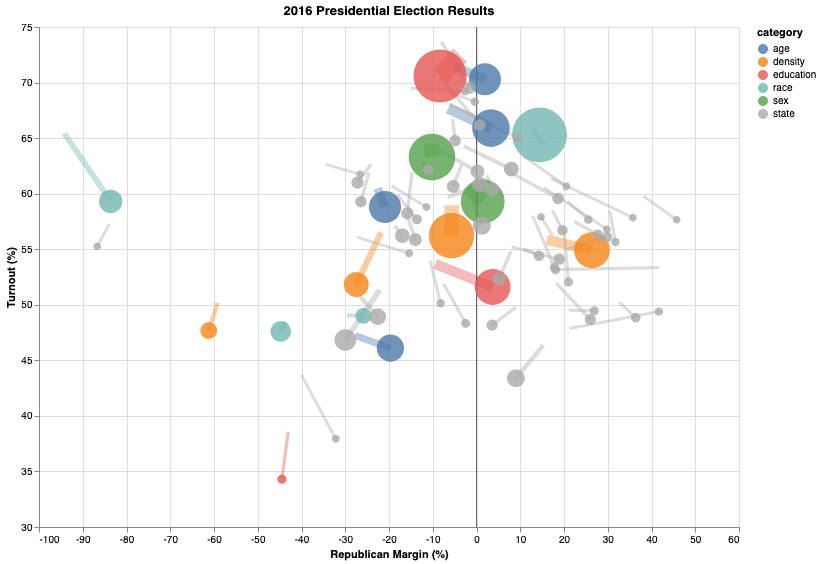

In [12]:
#colors = ['blue', 'orange', 'red', 'lightblue', 'grey', 'green'] #range=colors
colors = ['rgb(76, 120, 168)', 'rgb(245, 133, 24)', 'rgb(228, 87, 86)',
    'rgb(114, 183, 178)', 'rgb(84, 162, 75)','#aaa']  #rgb(186, 176, 172) #666
scheme = 'tableau20' #tableau20 'dark2'  scheme = 'category20' category10

plot_df = stvis_df.copy()
plot_df['dem_margin'] = plot_df['dem_margin']*100
plot_df['rep_margin'] = -1*plot_df['dem_margin'] #Flip to R-margin
#plot_df['category'] = plot_df['category'].replace('gender', 'sex') #Technically sex, not gender. Done above
plot_df['turnout'] = plot_df['turnout']*100
plot_df = plot_df.round(2)

# Using dem_margin
# lines = alt.Chart(plot_df).mark_line().encode(
#     x=alt.X('dem_margin'),
#     y=alt.Y('turnout'),
#     detail='group',
#     #color='category',
#     color=alt.Color('category', scale=alt.Scale(range=colors), legend=None),
#     #color=alt.Color('category', scale=alt.Scale(scheme=scheme)),  
#     opacity=alt.value(0.4),
#     strokeWidth=alt.StrokeWidth('num:Q',
#         legend=None,
#         scale=alt.Scale(
#             #domain=[0,100000000],
#             range=[3, 20]
#         )
#     )
# ) #.interactive()

# circles = alt.Chart(plot_df[plot_df.year == 2016]).mark_point().encode(
#     x=alt.X('dem_margin', scale=alt.Scale(domain=[-50, 95]), title='Democratic Margin (%)'),  
#     y=alt.Y('turnout', scale=alt.Scale(zero=False, domain=[30, 75]), title='Turnout (%)'),
#     size= alt.Size('num:Q', scale=alt.Scale(range=[50,3000]), legend=None),  #[50,2000] [25,3000] , legend=None
#     tooltip=[alt.Tooltip('group:N'), alt.Tooltip('dem_margin:Q'),
#         alt.Tooltip('turnout:Q'), alt.Tooltip('num:Q', format=',.0f')],  # format='.1%' .0f
#     opacity=alt.value(0.8), #0.75
#     #fill=alt.Color('dem_margin', scale=alt.Scale(domain=[-0.5,0.5], range=['red','purple','blue']))
#     fill=alt.Color('category', scale=alt.Scale(range=colors)),
#     #fill=alt.Color('category', scale=alt.Scale(scheme=scheme)),
#     #fill=alt.Color('category'),
#     order=alt.Order("num:Q", sort="descending")   
# )

# Using rep_margin, makes more sense because rightward shift = move to the right politically
lines = alt.Chart(plot_df).mark_line().encode(
    x=alt.X('rep_margin'),
    y=alt.Y('turnout'),
    detail='group',
    #color='category',
    color=alt.Color('category', scale=alt.Scale(range=colors), legend=None),
    #color=alt.Color('category', scale=alt.Scale(scheme=scheme)),  
    opacity=alt.value(0.4),
    strokeWidth=alt.StrokeWidth('num:Q',
        legend=None,
        scale=alt.Scale(
            #domain=[0,100000000],
            range=[3, 20]
        )
    )
) #.interactive()

circles = alt.Chart(plot_df[plot_df.year == 2016]).mark_point().encode(
    x=alt.X('rep_margin', scale=alt.Scale(domain=[-95, 50]), title='Republican Margin (%)'),  
    y=alt.Y('turnout', scale=alt.Scale(zero=False, domain=[30, 75]), title='Turnout (%)'),
    size= alt.Size('num:Q', scale=alt.Scale(range=[50,3000]), legend=None),  #[50,2000] [25,3000] , legend=None
    tooltip=[alt.Tooltip('group:N'), alt.Tooltip('rep_margin:Q'),
        alt.Tooltip('turnout:Q'), alt.Tooltip('num:Q', format=',.0f')],  # format='.1%' .0f
    opacity=alt.value(0.8), #0.75
    #fill=alt.Color('dem_margin', scale=alt.Scale(domain=[-0.5,0.5], range=['red','purple','blue']))
    fill=alt.Color('category', scale=alt.Scale(range=colors)),
    #fill=alt.Color('category', scale=alt.Scale(scheme=scheme)),
    #fill=alt.Color('category'),
    order=alt.Order("num:Q", sort="descending")   
)


#https://github.com/altair-viz/altair/issues/1124
zero_axis = pd.DataFrame({'x': [0],'y': [0]}) #
x = alt.Chart(zero_axis).mark_rule().encode(x=alt.X('x:Q'), opacity=alt.value(0.6))
y = alt.Chart(zero_axis).mark_rule().encode(y='y:Q', opacity=alt.value(0.6))

#https://altair-viz.github.io/gallery/bar_chart_with_mean_line.html
# text = circles.mark_text(
# #     align='bottom',
# #     baseline='middle'
# #     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text=alt.Text('group:N'), #, format=".3"
#     size=alt.value(12),
#     fill=alt.value('black')
# )


chart = alt.layer(lines, x, y, circles).properties(
    title='2016 Presidential Election Results',
    background='#fff',
    width=700,
    height=500,
).interactive()


#Output chart
chart.save('onevis.html')

chart
# Think about using mart_trail to make shooting stars?
# https://altair-viz.github.io/gallery/trail_marker.html
# Think about color coding by group too, because you don't need to color by margin -- it's already in the plot!
#Maybe the best visualization is a table??
#So have color coded table with Turnout, Margin, changes in both, and then sort by group size,
#from largest to smallest. So it would start with sex, 
# Or maybe have a "consequence" column that is the total changes in votes +- for that group, and sort by absolute
# value.

#The male/female numbers are correct, at least the turnout.  And it's mathematically impossible
#to have all turnouts for a category beneath all turnouts for another category.  It HAS to be made up 
#somewhere, or at least asymptotically equal to it. 
#So the problem seems to be the county data aggregation I did. 

In [11]:
# Just use it as is for now? Explain that it's a problem that e.g. every density bubble has a lower
# turnout than every gender bubble. This is mathematically impossible, but it's the result of 
# errors in demographic measurement magnified to scale of the whole population. 

# Note: the county data uses Voting Age Population data, and the census bureau demographic data from
# the elections project uses CITIZEN Voting Age Population data, so this might account for the discrepancie.
# http://www.electproject.org/home/voter-turnout/demographics
# Just explain this, mention that you might use different Catalist data + Elections Project + MIT County
# Data in the future when I get the time to parse through them all. Directions and magnitude seem correct,
# just question of if the levels are right?

# https://stackoverflow.com/questions/10951341
groups = stvis_df[stvis_df.year == 2016].groupby(by='category')

def check_turnout(group):
    num_total = group['num'].sum()
    # Calculated role each turnout should play in overall turnout,
    # then sum each value to get overall turnout estimate
    return ((group['num']/num_total)*group['turnout']).sum()
     
check_df = groups.apply(check_turnout)
check_df = check_df.to_frame(name='national_turnout')
check_df
# https://en.wikipedia.org/wiki/United_States_presidential_election,_2016
# Overall turnout was 55.4% VAP and 60.2% VEP
# I think the problem with my approach here is that I'm using VAP data for 
# the counties, but maybe VEP was used to calculate the demographic numbers?
# Nope, the demographic data is from Citizen Voting Age Population (The age, education, race data)
# http://www.electproject.org/home/voter-turnout/demographics
# But I think I used the values that were corrected for nonresponse

NameError: name 'stvis_df' is not defined